# Identifiability

##### Keywords:  identifiability, MCMC, bayesian

## Contents
{:.no_toc}
* 
{: toc}

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We generate some test data from $N(0,1)$:

In [4]:
from scipy.stats import norm
data = norm.rvs(size=100)
data

array([ 0.03962073,  0.03290953,  0.98544195,  0.04596463,  0.64626776,
       -1.51917579, -0.47099774, -0.79274817, -1.510941  ,  0.62187968,
       -1.58463447, -0.31167464,  1.09177345,  1.86007596, -0.34114228,
       -0.35475686,  0.70235072, -0.87451605, -1.14164176, -1.33450384,
       -1.66049335,  0.42916234, -1.45189161, -1.80733019, -1.34731763,
        0.5692819 , -1.54416497,  0.06534625, -1.42065169, -0.20115099,
        1.13634278,  0.33987116,  0.40928055, -0.79304293, -1.42792586,
       -0.49092787, -0.40731762,  0.36158092,  0.55836612,  0.94629738,
        0.37472964,  0.67798211,  0.47590639, -0.00241526,  1.84591318,
        0.24104702,  0.22500321, -1.71406405,  2.17130125, -0.4478053 ,
        0.51994149, -0.56184292,  0.2997452 , -0.27366469, -0.90988938,
        1.0146704 , -0.99058279, -0.29684026, -1.43256059,  0.03973359,
        1.09712035,  0.46719219,  0.80223718,  1.54859038, -0.94135931,
       -0.20712364, -0.21525818, -0.84091686,  0.16319026, -0.35

We fit this data using the following model:

$$
y \sim N(\mu, \sigma)\\
\mu = \alpha_1 + \alpha_2\\
\alpha_1 \sim Unif(-\infty, \infty)\\
\alpha_2 \sim Unif(-\infty, \infty)\\
\sigma \sim HalfCauchy(0,1)
$$

In [5]:
import pymc3 as pm

In our sampler, we have chosen `njobs=2` which allows us to run on multiple processes, generating two separate chains.

In [21]:
with pm.Model() as ni:
    sigma = pm.HalfCauchy("sigma", beta=1)
    alpha1=pm.Uniform('alpha1', lower=-10**6, upper=10**6)
    alpha2=pm.Uniform('alpha2', lower=-10**6, upper=10**6)
    mu = pm.Deterministic("mu", alpha1 + alpha2)
    y = pm.Normal("data", mu=mu, sd=sigma, observed=data)
    stepper=pm.Metropolis()
    traceni = pm.sample(100000, step=stepper, njobs=2)

100%|██████████| 100000/100000 [01:17<00:00, 1286.59it/s]| 1/100000 [00:00<3:20:31,  8.31it/s]


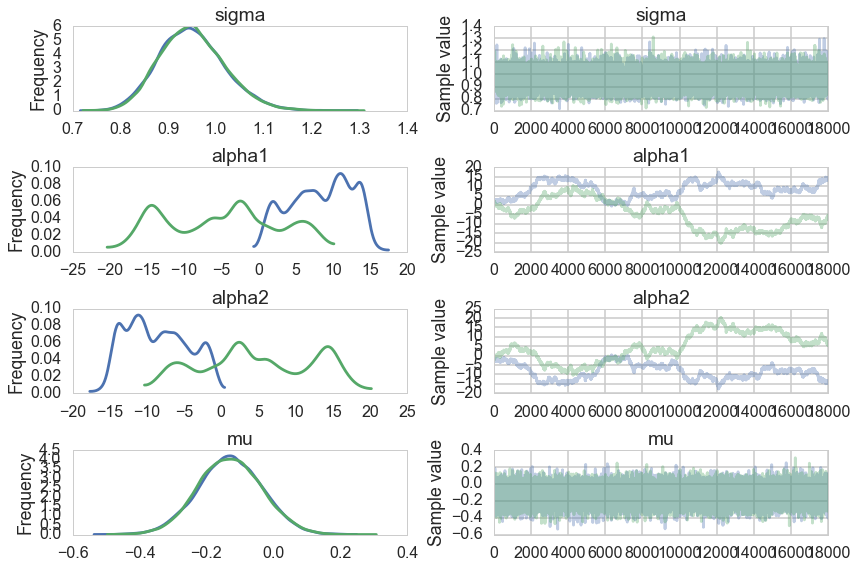

In [22]:
pm.traceplot(traceni);

Look at our traces for $\alpha_1$ and $\alpha_2$. These are bad, and worse, they look entirely different for two chains. Despite this, $\mu$ looks totally fine. Our trac

In [37]:
df=pm.trace_to_dataframe(traceni)
df.corr()

,sigma,mu,alpha1,alpha2
sigma,1.000000,-0.000115,-0.003153,0.003152
mu,-0.000115,1.000000,0.002844,0.008293
alpha1,-0.003153,0.002844,1.000000,-0.999938
alpha2,0.003152,0.008293,-0.999938,1.000000


Just like in our uncentered regression example, we have $\alpha_1$ and $\alpha_2$ sharing information: they are totally negatively correlated and unidentifiable. Indeed our intuition probably told us as much.

In [24]:
pm.summary(traceni)


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.950            0.068            0.000            [0.821, 1.086]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.827          0.903          0.947          0.994          1.095


alpha1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.730            9.037            0.897            [-15.433, 14.707]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -16.135        -4.079         3.764          8.813          14.291


alpha2:

  Mean             SD               MC Error         95% HPD interval
  -------------------

A look at the effective number of samples using two chains tells us that we have only one effective sample for $\alpha_1$ and $\alpha_2$.

In [30]:
pm.effective_n(traceni)

{'alpha1': 1.0,
 'alpha1_interval_': 1.0,
 'alpha2': 1.0,
 'alpha2_interval_': 1.0,
 'mu': 26411.0,
 'sigma': 39215.0,
 'sigma_log_': 39301.0}

The Gelman-Rubin statistic is awful for them. No convergence.

In [31]:
pm.gelman_rubin(traceni)

{'alpha1': 1.7439881580327452,
 'alpha1_interval_': 1.7439881580160093,
 'alpha2': 1.7438626593529831,
 'alpha2_interval_': 1.7438626593368223,
 'mu': 0.99999710182062695,
 'sigma': 1.0000248056117549,
 'sigma_log_': 1.0000261752214563}

Its going to be hard to break this unidentifiability. We try by forcing $\alpha_2$ to be negative in our prior

In [44]:
with pm.Model() as ni2:
    sigma = pm.HalfCauchy("sigma", beta=1)
    alpha1=pm.Normal('alpha1', mu=5, sd=1)
    alpha2=pm.Normal('alpha2', mu=-5, sd=1)
    mu = pm.Deterministic("mu", alpha1 + alpha2)
    y = pm.Normal("data", mu=mu, sd=sigma, observed=data)
    #stepper=pm.Metropolis()
    #traceni2 = pm.sample(100000, step=stepper, njobs=2)
    traceni2 = pm.sample(100000, njobs=2)

100%|██████████| 100000/100000 [06:30<00:00, 255.83it/s]


Notice we are using the built in NUTS sampler. It takes longer but explores the distributions far better: more on this after our course break.

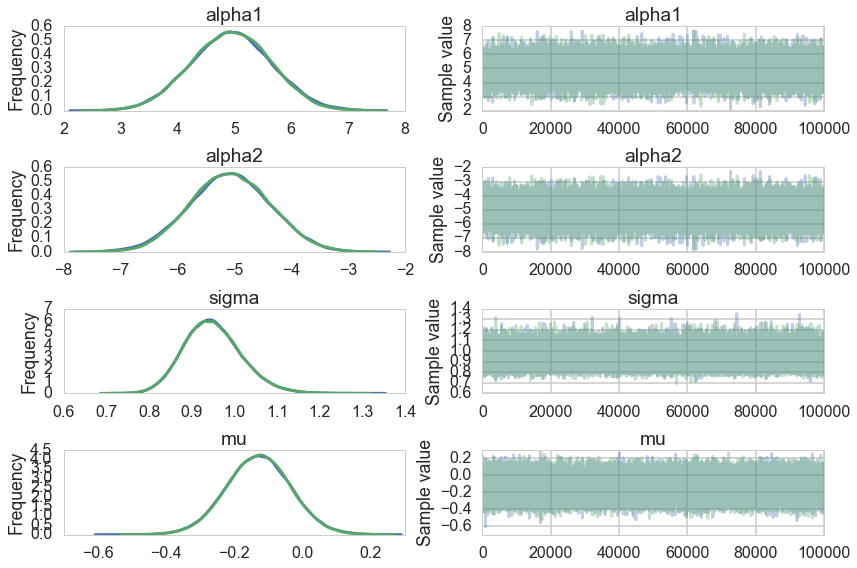

In [45]:
pm.traceplot(traceni2);

Our extremely strong priors have helped us do a much better job.

In [46]:
pm.summary(traceni2)


alpha1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.944            0.707            0.004            [3.560, 6.314]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.562          4.465          4.946          5.424          6.319


alpha2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -5.074           0.707            0.004            [-6.471, -3.712]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -6.450         -5.552         -5.076         -4.593         -3.690


sigma:

  Mean             SD               MC Error         95% HPD interval
  --------------------

Our effective sample size is still poor and our traces still look dodgy, but things are better. 

In [47]:
pm.effective_n(traceni2)

{'alpha1': 21779.0,
 'alpha2': 21771.0,
 'mu': 200000.0,
 'sigma': 155001.0,
 'sigma_log_': 156987.0}

In [48]:
pm.gelman_rubin(traceni2)

{'alpha1': 1.0000646992489557,
 'alpha2': 1.0000681135686484,
 'mu': 0.99999730757810168,
 'sigma': 1.0000011955172152,
 'sigma_log_': 1.000002093954572}

..and this shows in our Gelman-Rubin statistics as well...

In [49]:
pm.trace_to_dataframe(traceni2).corr()

,alpha1,alpha2,mu,sigma
alpha1,1.000000,-0.991091,0.066087,0.000749
alpha2,-0.991091,1.000000,0.067395,-0.000322
mu,0.066087,0.067395,1.000000,0.003204
sigma,0.000749,-0.000322,0.003204,1.000000


..but our unidentifiability is still high when we look at the correlation. This reflects the fundamental un-identifiability and sharing of information in our model since $\mu = \alpha_1 +\alpha_2$: all the priors do is artificially peg one of the parameters. And once one is pegged the other is too because of the symmetry.